In [10]:
import math
import numpy as np
import seaborn as sbs
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib_inline
import pandas as pd
from sklearn.model_selection import train_test_split as ttsplit
from torch.utils.data import TensorDataset, DataLoader

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [11]:
def get_wine():
    wine_df = None
    try:
        wine_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
        wine_df['bool_quality'] = (wine_df['quality'] > 5).astype(int)
        wine_df.drop('quality', axis=1, inplace=True)
        wine_df = wine_df[wine_df['total sulfur dioxide']<200]
        display(wine_df.head())
        yield wine_df
    finally:
        if wine_df is not None:
            del wine_df

def prep_wine(batch_size=None):
    for df in get_wine():
        features = torch.tensor(df.iloc[:,:11].values, dtype=torch.float32)
        labels = torch.tensor(df['bool_quality'].factorize()[0], dtype=torch.long)
        
        X_train, X_test, y_train, y_test = ttsplit(features, labels, test_size=.2, shuffle=True)
        # Calculate batch size: 20% of data, rounded to nearest power of 2, capped at 32
        if batch_size:
            batch_size = batch_size
        else:
            small_batch_threshhold = max(4, int(0.2 * len(X_train)))
            batch_size = min(32, 1 << int(math.log2(small_batch_threshhold)))
            
        
        return (TensorDataset(X_train, y_train), 
                TensorDataset(X_test, y_test),
                X_train.shape[1],
                y_train.max().item() + 1,
                batch_size)


training_set, testing_set, n_features, n_predictions, batch_size = prep_wine()
train_loader = DataLoader(training_set, batch_size, shuffle=True)
test_loader = DataLoader(testing_set)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,bool_quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [12]:
class MyANN(nn.Module):
    
    def __init__(self, features = n_features, 
                 predictions = n_predictions, 
                 neurons_p_layer = 10, 
                 hidden_layers = 2):
        super().__init__()

        
        self.n_hidden = hidden_layers
        self.layers = nn.ModuleDict()
        
        # Regularization
        self.l1 = 0.000
        self.l2 = 0.000
        self.dr = 0.0

        self.layers['input'] = nn.Linear(features, neurons_p_layer)

        for _ in range(self.n_hidden):
            self.layers[f'hidden_{_}'] = nn.Linear(neurons_p_layer, neurons_p_layer)

        self.layers['output'] = nn.Linear(neurons_p_layer, predictions)

    def forward(self, x):

        x = F.relu(self.layers['input'](x))
        if self.dr:
            x = F.dropout(x, p=self.dr, training=self.training)

        for _ in range(self.n_hidden):
            x = F.relu(self.layers[f'hidden_{_}'](x))
            if self.dr:
                x = F.dropout(x, p=self.dr, training=self.training)

        x = self.layers['output'](x)

        return x

In [13]:
def train_model(model, n_epochs = 500, lr=0.1):

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=model.l2)
    loss_calc = nn.CrossEntropyLoss()
    
    
    train_acc = []
    test_acc = []
    for i in range(n_epochs):
        
        batch_acc = []
        model.train()
        for X, y in train_loader:

            y_hat = model(X)
            loss = loss_calc(y_hat, y)

            if model.l1:
                for name, param in model.named_parameters():
                    if 'bias' not in name:
                        l1_adj = param.abs().sum() * model.l1
                        loss += l1_adj
            


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            top_pred = torch.argmax(y_hat, axis=1)
            batch_acc.append(100*torch.mean((top_pred==y).float()).item())

        
        train_acc.append(np.mean(batch_acc))
        
        model.eval()
        with torch.no_grad():
            X, y = testing_set.tensors
            y_hat = model(X)
            test_pred = torch.argmax(y_hat, axis=1)
            test_acc.append(100*torch.mean((test_pred==y).float()).item())

    return train_acc, test_acc


In [14]:
def smooth(x, k=5):
    return np.convolve(x, np.ones(k)/k, mode='same')

Features: 11, Classes: 2, Batch size: 32


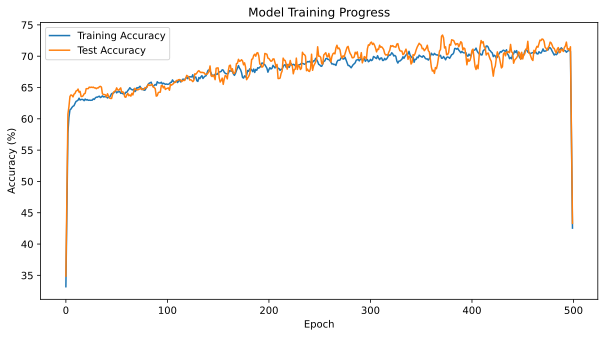

In [15]:
# Your data is already prepared from prep_iris_efficient()
print(f"Features: {n_features}, Classes: {n_predictions}, Batch size: {batch_size}")

# Create and train model
my_model = MyANN()

# regularization
if 0:
    my_model.dr = 0.1 # nodes to turn off in forward pass
    my_model.l1 = 0.003 # strength of push toward 0 weight (fraction of absolute weights)
    my_model.l2 = 0.003 # penalizes large weights?

train_acc, test_acc = train_model(my_model, n_epochs=500, lr=0.01)


# Plot results
plt.figure(figsize=(10, 5))
plt.plot(smooth(train_acc), label='Training Accuracy')
plt.plot(smooth(test_acc), label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Model Training Progress')
plt.show()

In [33]:
my_y = np.zeros((10,10))
my_x = np.linspace(1, 10, 10)
for i in range(10):
    
    my_y[i]=[j + i for j in range(10)]
display(my_x[:])
my_y[3]


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

<function matplotlib.pyplot.show(close=None, block=None)>

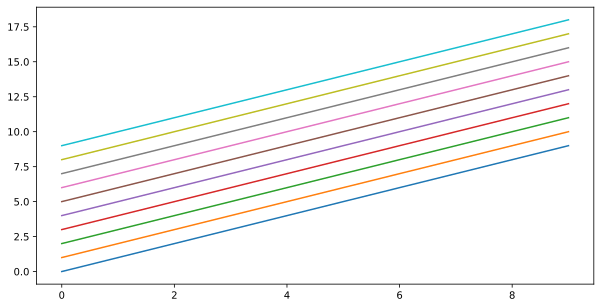

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(my_y)
plt.show

In [35]:
batch_size_list = [2,3,4,6,8,16,32]
train_y_data = np.zeros((7,500))
test_y_data = np.zeros((7,500))
training_set, testing_set, n_features, n_predictions, batch_size = prep_wine()
    
for i in range(len(batch_size_list)):    
    my_model = MyANN()
    train_loader = DataLoader(training_set, batch_size=batch_size_list[i], shuffle=True, drop_last=True)
    test_loader = DataLoader(testing_set)
    train_y_data[i], test_y_data[i] = train_model(my_model)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,bool_quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


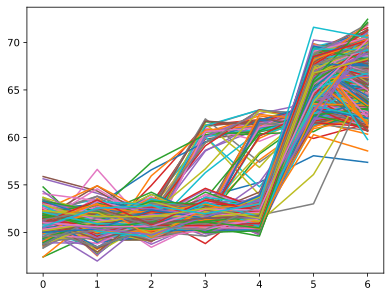

In [36]:
plt.plot(train_y_data)
plt.show()

In [41]:
train_y_data

array([[51.48902821, 51.80250784, 54.78056426, ..., 51.3322884 ,
        52.27272727, 50.62695925],
       [50.66666787, 49.88235401, 49.25490304, ..., 52.39215798,
        51.68627558, 52.5490208 ],
       [50.78369906, 50.54858934, 49.21630094, ..., 50.62695925,
        51.64576803, 52.82131661],
       ...,
       [55.2672956 , 57.62578616, 58.25471698, ..., 52.75157233,
        51.49371069, 52.98742138],
       [58.06962025, 61.70886076, 62.34177215, ..., 67.56329114,
        66.7721519 , 71.59810127],
       [57.37179487, 60.33653846, 61.45833333, ..., 69.39102564,
        68.26923077, 70.51282051]], shape=(7, 500))

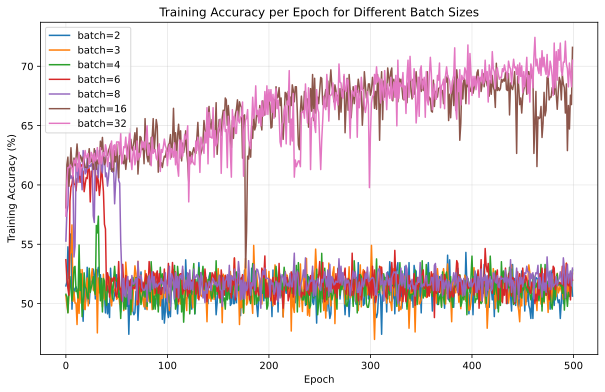

In [42]:
epochs = np.arange(train_y_data.shape[1])  # 0 to 499

plt.figure(figsize=(10, 6))
for i, batch_size in enumerate(batch_size_list):
    plt.plot(epochs, train_y_data[i], label=f'batch={batch_size}')

plt.xlabel('Epoch')
plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy per Epoch for Different Batch Sizes')
plt.legend()
plt.grid(alpha=0.3)
plt.show()